In [511]:
import gym # openAi gym
from gym import envs
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from time import sleep
from numpy import random
import time
plt.rcParams.update({'font.size': 16})
import mdptoolbox, mdptoolbox.example
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

In [512]:
# create Taxi environment
env = gym.make('Taxi-v3', render_mode='ansi')
env.reset()

num_steps = 10
for s in range(num_steps+1):
    print(f"step: {s} out of {num_steps}")
    action = env.action_space.sample()
    env.step(action)
    print(env.render()) # Print in ansii mode
env.close()

step: 0 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

step: 1 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

step: 2 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

step: 3 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

step: 4 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

step: 5 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

step: 6 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

step: 7 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

step: 8 out of 10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---

C:\Users\vyassum\.pyenv\pyenv-win\versions\3.10.1\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [513]:
def get_number_of_steps(env, policy, episodes=10):
    misses = 0
    steps_for_all_episodes = []
    for each_episode in range(episodes):
        print (f"Episode {each_episode} out of {episodes}")
        state = env.reset()[0]
        steps = 0
        while True:
            action = policy[state]
            state, reward, done, _, prob = env.step(action)
            steps += 1
            if done and reward == 0:
                misses += 1
                break
            elif done and reward == 1:
                steps_for_all_episodes.append(steps)
                break
    mean_steps = np.mean(steps_for_all_episodes)
    std_steps = np.std(steps_for_all_episodes)
    fail_percentage = (misses/episodes) * 100
    return mean_steps, std_steps, fail_percentage

In [514]:
def construct_transition_matrix(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    P = np.zeros((n_actions, n_states, n_states))
    for s in range(n_states):
        for a in range(n_actions):
            for transition in env.P[s][a]:
                probability, next_state, reward, done = transition
                P[a, s, next_state] += probability
    return P

def construct_reward_matrix(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    R = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            for transition in env.P[s][a]:
                probability, next_state, reward, done = transition
                R[s, a] = reward
    return R

In [515]:
def run_episodes(env, num_games, policy,  random=False):
    total_reward = 0
    total_wins = 0
    for _ in range(num_games):
        state = env.reset()[0]
        done = False
        while not done:
            if random:
                action = env.action_space.sample()
            else:
                action = policy[state]
            state, reward, done, info, _ = env.step(action)
            total_reward += reward
            if done:
                total_wins+=1
                break
                
    avg_reward = total_reward / num_games
    return total_wins,total_reward, avg_reward

In [516]:
def calculate_state_value_function(env, state, V, discount_factor):
    A = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, info in env.P[state][a]:
            A[a] += prob * (reward + discount_factor * V[next_state])
    return A

def update_policy(env, policy, V, discount_factor):
    for each_state in range(env.observation_space.n):
        A = calculate_state_value_function(env, each_state, V, discount_factor)
        best_action = np.argmax(A)
        policy[each_state] = best_action
    return policy

## Experiment 1 - VI

In [517]:
def run_vi_exp_1(t, r, gamma_values, epsilons, max_iterations=1000):
    # Experiments w.r.t gamma and epsilon
    start_time = time.time()
    value_iterations = []

    test_number = 0

    for gamma in gamma_values:
        for epsilon in epsilons:
            print (epsilon, gamma)
            vi = ValueIteration(t, r, gamma, epsilon, max_iter=max_iterations)
            test_run = vi.run()

            max_reward = test_run[-1]['Reward'] # max reward
            time_to_converge = test_run[-1]['Time'] # time to converge
            num_iters = test_run[-1]['Iteration'] # number of iterations to converge
            reward = test_run[-1]['Max V'] # max V value

            # Collect mean V, max V and errors
            max_r, mean_r, errors = [], [], []
            for run in test_run:
                max_r.append(run['Max V'])
                mean_r.append(run['Mean V'])
                errors.append(run['Error'])

            policy = np.array(vi.policy)
            #policy
            #policy = policy.reshape((4,4))
            value_iterations.append([gamma, epsilon, max_reward, time_to_converge, 
                                     num_iters, reward, max(max_r), max(mean_r), max(errors), policy])
            test_number += 1
            end_time = time.time() - start_time

    #print ("Policy>>",policy)

    value_iterations_df = pd.DataFrame(value_iterations, columns=['Gamma', 'Epsilon', 'Max Reward', 'Time to Converge', 'Num Iters', 'Reward', 'Max V (All)', 'Mean V (All)', 'Errors', 'Policy'])
    #print('Time to converge: ', end_time)

    #print (value_iterations_df.head())
    
    # See differences in policy
    policies = value_iterations_df['Policy']
    value_iterations_df.fillna(0, inplace=True)
    return value_iterations_df

In [518]:
# Changing value of Gamma
gamma_values = [0.1,0.2, 0.3, 0.5, 0.7, 0.9, 0.99]
epsilons = [1e-2, 1e-3, 1e-5, 1e-8]

# Define the transition probability matrix and reward matrix from the environment
P = construct_transition_matrix(env)
R = construct_reward_matrix(env)

value_iterations = run_vi_exp_1(P, R, gamma_values, epsilons)
value_iterations.to_csv('value_iterations_taxi.csv', index=False)
value_iterations.head()

0.01 0.1
0.001 0.1
1e-05 0.1
1e-08 0.1
0.01 0.2
0.001 0.2
1e-05 0.2
1e-08 0.2
0.01 0.3
0.001 0.3
1e-05 0.3
1e-08 0.3
0.01 0.5
0.001 0.5
1e-05 0.5
1e-08 0.5
0.01 0.7
0.001 0.7
1e-05 0.7
1e-08 0.7
0.01 0.9
0.001 0.9
1e-05 0.9
1e-08 0.9
0.01 0.99
0.001 0.99
1e-05 0.99
1e-08 0.99


,Gamma,Epsilon,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy
0,0.1,1.000000e-02,20.10000,0.016352,3,20.10000,20.10000,-0.832,21.0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.1,1.000000e-03,20.09900,0.024438,4,20.09900,20.10000,-0.832,21.0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.1,1.000000e-05,20.10099,0.031417,6,20.10099,20.10100,-0.832,21.0,"[4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.1,1.000000e-08,20.10101,0.053718,9,20.10101,20.10101,-0.832,21.0,"[4, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.2,1.000000e-02,20.59200,0.025711,4,20.59200,20.60000,-0.832,21.0,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


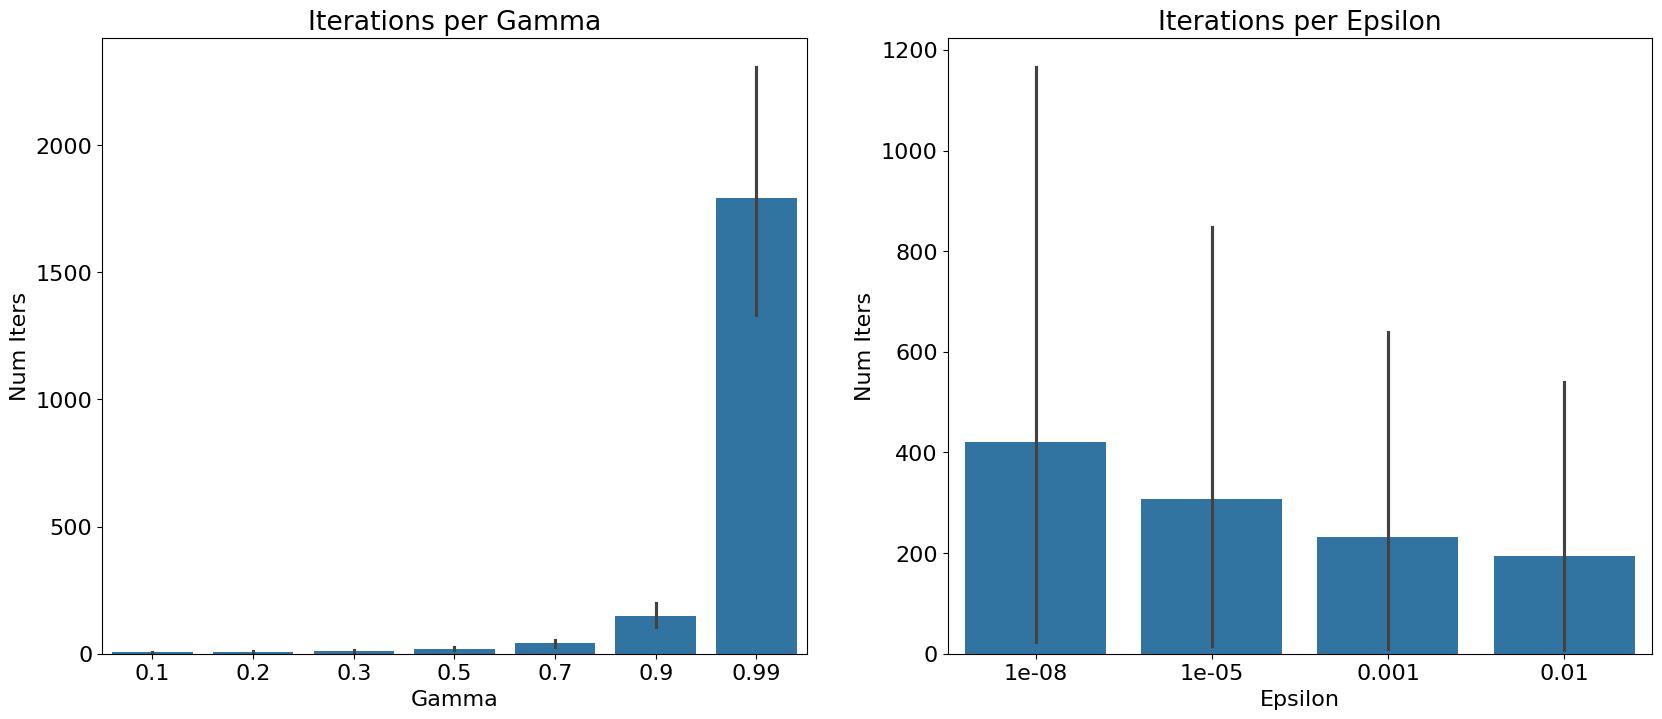

In [519]:
# Plot (Iterations vs Gamma) in one subplot and (Iterations vs Epsilon) in another subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Gamma', y='Num Iters', data=value_iterations, ax=ax[0])
ax[0].set_title('Iterations per Gamma')
sns.barplot(x='Epsilon', y='Num Iters', data=value_iterations, ax=ax[1])
ax[1].set_title('Iterations per Epsilon')
plt.show()

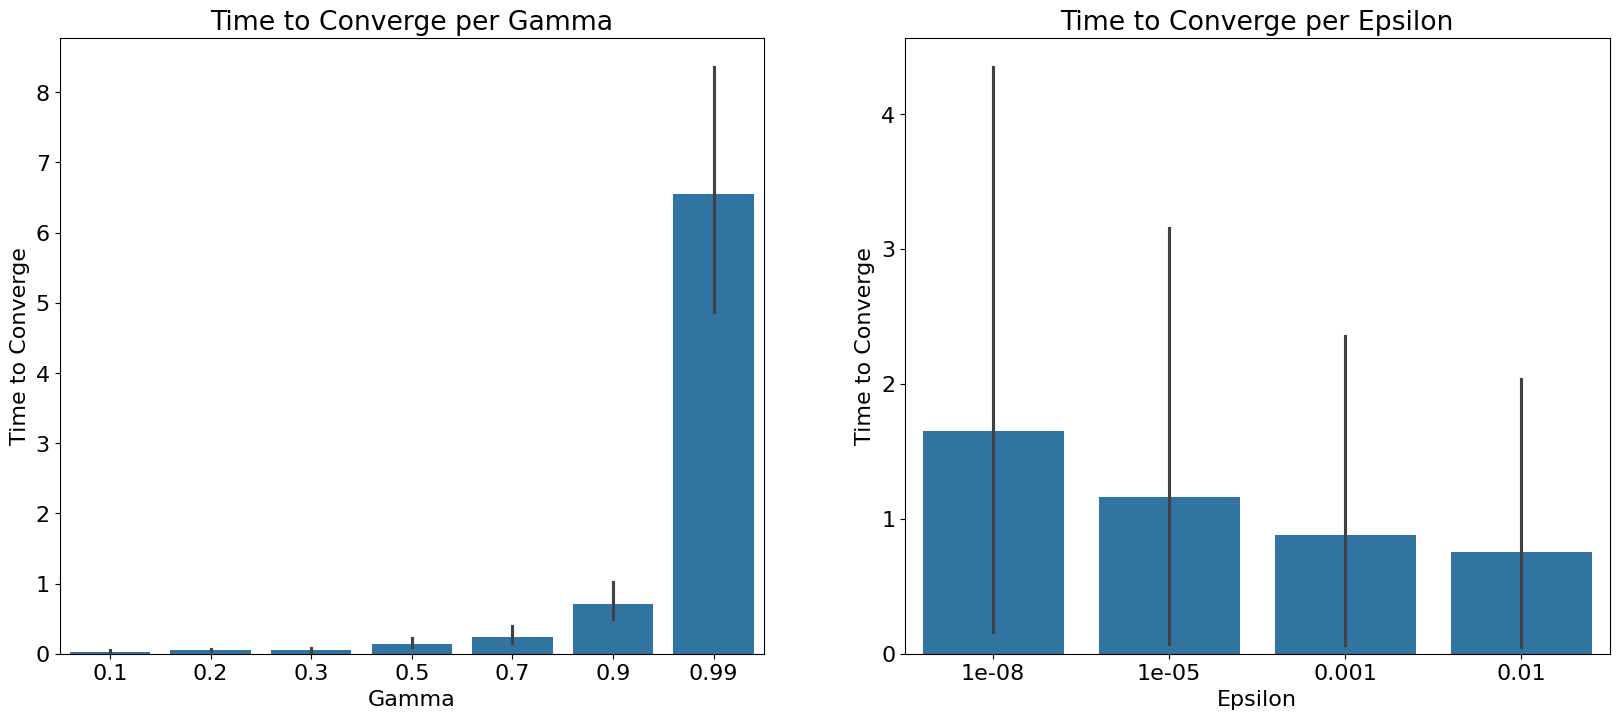

In [520]:
# Plot (convergence time vs Gamma) in one subplot and (convergence time vs Epsilon) in another subplot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Gamma', y='Time to Converge', data=value_iterations, ax=ax[0])
ax[0].set_title('Time to Converge per Gamma')
sns.barplot(x='Epsilon', y='Time to Converge', data=value_iterations, ax=ax[1])
ax[1].set_title('Time to Converge per Epsilon')
plt.show()

## Experiment 2 - VI

In [521]:
def run_vi_exp_2(env, discount_factor, max_iterations=1000):
    # Experiments w.r.t different number of iterations
    V = np.zeros(env.observation_space.n)
    for i in range(max_iterations):
        #print (f"inner i {i}")
        prev_v = np.copy(V) 
        for state in range(env.observation_space.n):
            A = calculate_state_value_function(env, state, V, discount_factor)
            V[state] = np.max(A)
        if i % 10 == 0:
            if (np.all(np.isclose(V, prev_v))):
                break
    optimal_policy = np.zeros(env.observation_space.n, dtype=int)
    optimal_policy = update_policy(env, optimal_policy, V, discount_factor)
    
    return optimal_policy, V
            

In [522]:
discount_factors = [0.99, 0.9, 0.7, 0.5]
vi_iterations_results = []
iterations_range = range(20,200,20)
optimal_policies = {}

for each_discount in discount_factors:
    print (each_discount)
    for iter in iterations_range:
        print (f"iter {iter}")
        start_time = time.time()
        optimal_policy, V = run_vi_exp_2(env, each_discount, max_iterations=iter)
        env.reset()
        #print ("calculating rewards")
        wins, total_reward, avg_reward = run_episodes(env, 20, optimal_policy, random = False)
        end_time = time.time() - start_time
        vi_iterations_results.append([each_discount, iter, wins, total_reward, avg_reward, end_time])

vi_iterations_results_df = pd.DataFrame(vi_iterations_results, columns=['Discount Factor', 'Iterations','Wins', 'Total Reward', 'Average Reward', 'Time'])
vi_iterations_results_df.to_csv("vi_iterations_results_df_taxi_1.csv", index=False)
    
    


0.99
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
0.9
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
0.7
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
0.5
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180


In [523]:
vi_iterations_results_df

,Discount Factor,Iterations,Wins,Total Reward,Average Reward,Time
0,0.99,20,20,162,8.10,0.353740
1,0.99,40,20,144,7.20,0.673325
2,0.99,60,20,162,8.10,1.105553
3,0.99,80,20,168,8.40,1.307068
4,0.99,100,20,178,8.90,1.660067
5,0.99,120,20,163,8.15,2.060417
6,0.99,140,20,162,8.10,2.271422
7,0.99,160,20,157,7.85,2.641693
8,0.99,180,20,136,6.80,2.963544
9,0.90,20,20,165,8.25,0.353452


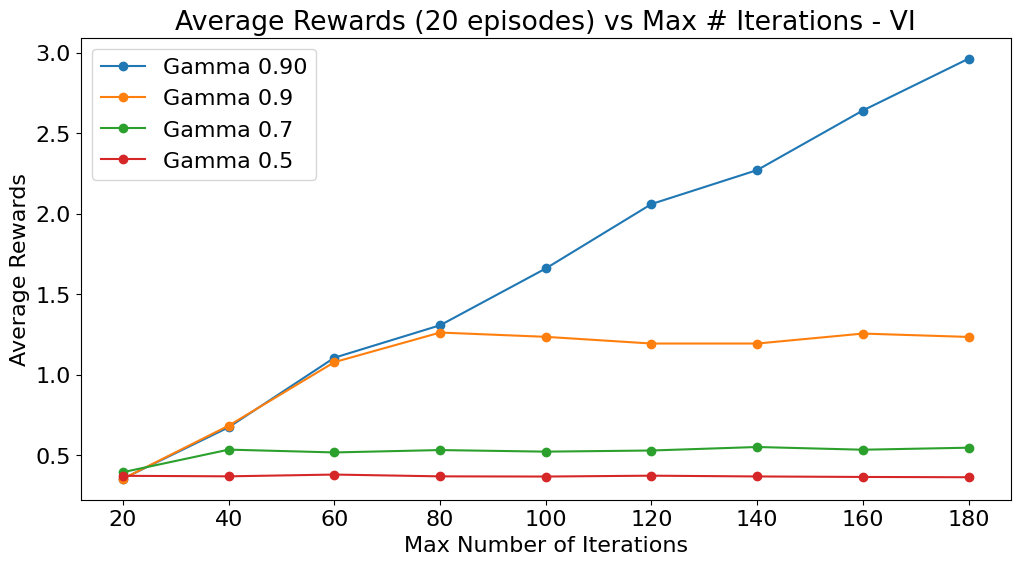

In [524]:
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.99, "Time"],marker='o', label='Gamma 0.90')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.9, "Time"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.7, "Time"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.5, "Time"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (20 episodes) vs Max # Iterations - VI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

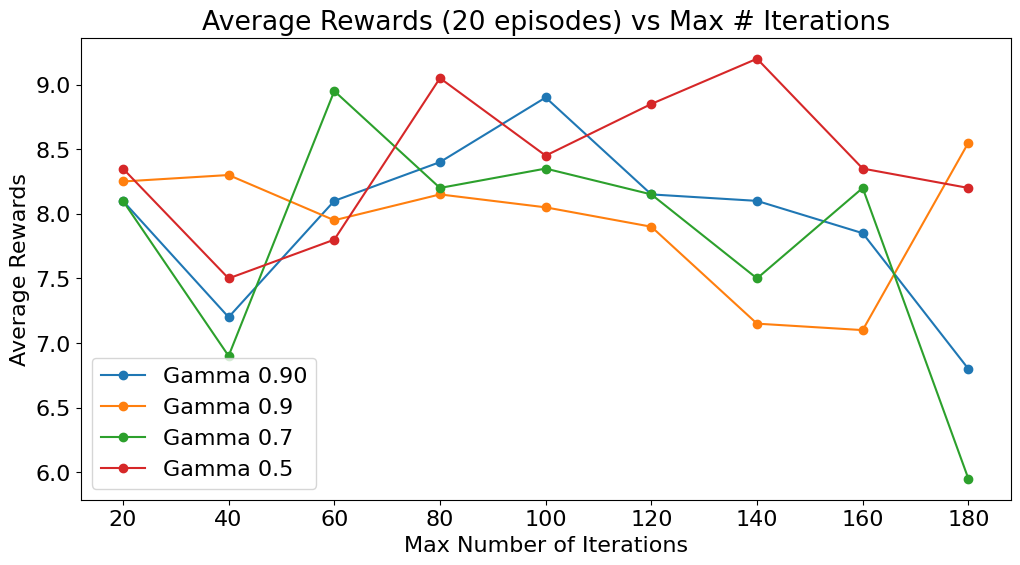

In [525]:
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.99, "Average Reward"],marker='o', label='Gamma 0.90')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.9, "Average Reward"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.7, "Average Reward"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==0.5, "Average Reward"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (20 episodes) vs Max # Iterations')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

Text(0.5, 1.0, 'Average Rewards vs Discount Factors')

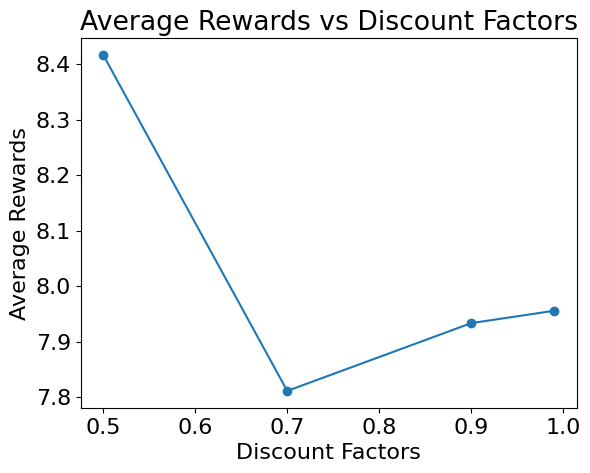

In [526]:
y = [vi_iterations_results_df.loc[vi_iterations_results_df['Discount Factor']==g, "Average Reward"].mean() for g in discount_factors]
plt.plot(discount_factors, y, marker='o')
plt.xlabel("Discount Factors")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Discount Factors")

# Policy Iteration

In [527]:
def run_pi_exp_1(t, r, gamma_values, max_iterations=1000):
    # Experiments w.r.t gamma and epsilon
    start_time = time.time()
    policy_iterations = []

    test_number = 0

    for gamma in gamma_values:
        
        vi = PolicyIteration(t, r, gamma, max_iter=max_iterations, eval_type="matrix")
        test_run = vi.run()

        max_reward = test_run[-1]['Reward'] # max reward
        time_to_converge = test_run[-1]['Time'] # time to converge
        num_iters = test_run[-1]['Iteration'] # number of iterations to converge
        reward = test_run[-1]['Max V'] # max V value

        # Collect mean V, max V and errors
        max_r, mean_r, errors = [], [], []
        for run in test_run:
            max_r.append(run['Max V'])
            mean_r.append(run['Mean V'])
            errors.append(run['Error'])

        policy = np.array(vi.policy)
        #policy
        #policy = policy.reshape((4,4))
        policy_iterations.append([gamma, max_reward, time_to_converge, 
                                    num_iters, reward, max(max_r), max(mean_r), max(errors), policy])
        test_number += 1
        end_time = time.time() - start_time

    #print ("Policy>>",policy)

    policy_iterations_df = pd.DataFrame(policy_iterations, columns=['Gamma', 'Max Reward', 'Time to Converge', 'Num Iters', 'Reward', 'Max V (All)', 'Mean V (All)', 'Errors', 'Policy'])
    #print('Time to converge: ', end_time)

    #print (value_iterations_df.head())
    
    # See differences in policy
    policies = policy_iterations_df['Policy']
    policy_iterations_df.fillna(0, inplace=True)
    return policy_iterations_df

In [528]:
# Changing value of Gamma
gamma_values = [0.1,0.2, 0.3, 0.5, 0.7, 0.9, 0.99]
epsilons = [1e-2, 1e-3, 1e-5, 1e-8]

# Define the transition probability matrix and reward matrix from the environment
P = construct_transition_matrix(env)
R = construct_reward_matrix(env)

policy_iterations = run_pi_exp_1(P, R, gamma_values)
policy_iterations.to_csv('policy_iterations_taxi_1.csv', index=False)
policy_iterations.head()

,Gamma,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy
0,0.1,20.101010,5.241275,16,20.101010,20.101010,-0.887497,2.100000,"[4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.2,20.625000,3.014106,16,20.625000,20.625000,-0.943819,4.200000,"[4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.3,21.648352,2.013663,16,21.648352,21.648352,-0.991725,6.300000,"[4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0.5,26.000000,3.783959,16,26.000000,26.000000,-0.915998,10.500000,"[4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0.7,37.843137,2.275873,16,37.843137,37.843137,0.897203,20.176471,"[4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


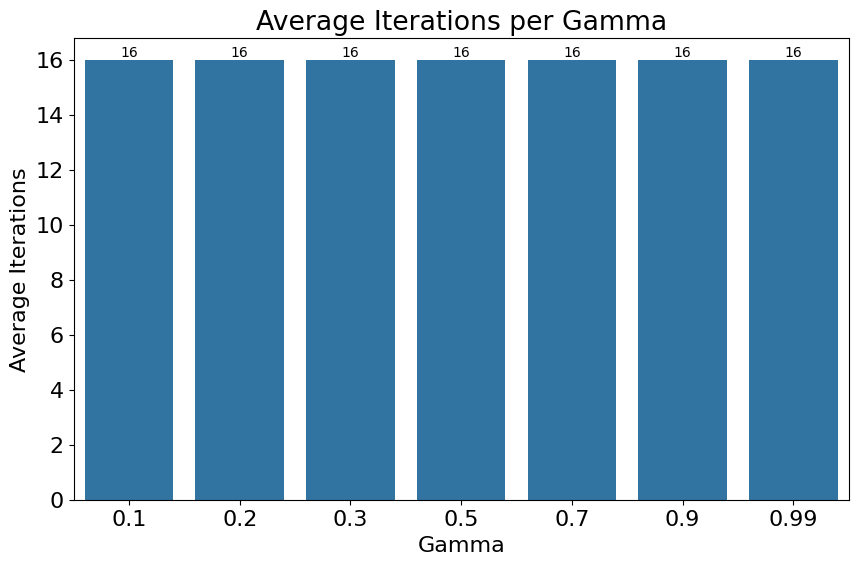

In [529]:
# PLot Iterations per gamma
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Num Iters', data=policy_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Iterations per Gamma')
plt.xlabel('Gamma')
plt.ylabel('Average Iterations')
plt.show()

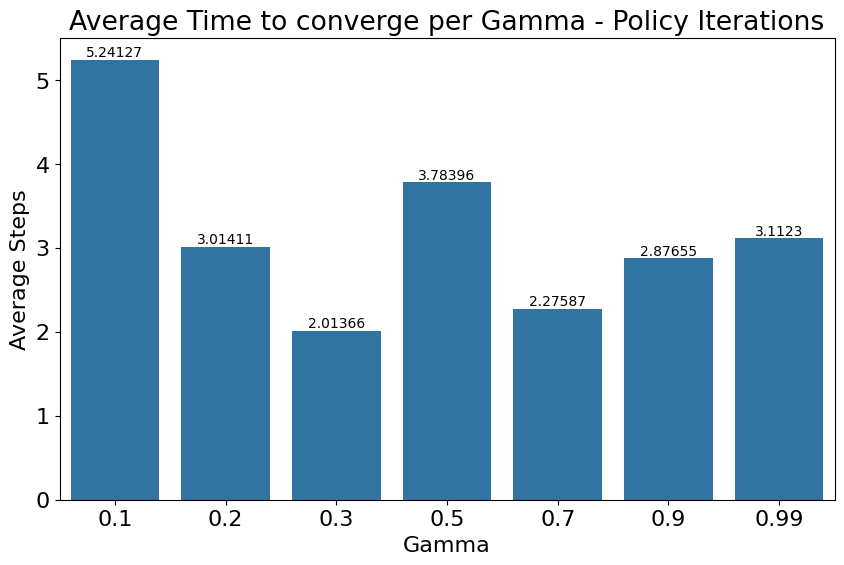

In [530]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Gamma', y='Time to Converge', data=policy_iterations)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('Average Time to converge per Gamma - Policy Iterations')
plt.xlabel('Gamma')
plt.ylabel('Average Steps')
plt.show()

# Experiment 2

In [531]:
def policy_eval(env, policy, V, discount_factor):
    policy_value = np.zeros(env.observation_space.n)
    for state in range(env.observation_space.n):
        action = policy[state]
        for prob, next_state, reward, info in env.P[state][action]:
            policy_value[state] += prob * (reward + discount_factor * V[next_state])
    return policy_value

def policy_iteration(env, discount_factor, max_iterations=1000):
    V = np.zeros(env.observation_space.n)
    policy = np.random.choice(env.action_space.n, env.observation_space.n)
    for i in range(max_iterations):
        prev_policy = np.copy(policy)
        V = policy_eval(env, policy, V, discount_factor)
        policy = update_policy(env, policy, V, discount_factor)
        if i % 10 == 0:
            if (np.all(np.equal(policy, prev_policy))):
               break
    return policy, V

In [533]:
discount_factors = [0.99, 0.9, 0.7, 0.5]
pi_iterations_results = []
iterations_range = range(20,500,20)
optimal_policies = {}

for each_discount in discount_factors:
    print (each_discount)
    for iter in iterations_range:
        print (f"iter {iter}")
        start_time = time.time()
        optimal_policy, V = policy_iteration(env, each_discount, max_iterations=iter)
        env.reset()
        #print ("calculating rewards")
        wins, total_reward, avg_reward = run_episodes(env, 20, optimal_policy, random = False)
        end_time = time.time() - start_time
        pi_iterations_results.append([each_discount, iter, wins, total_reward, avg_reward, end_time])

pi_iterations_results_df = pd.DataFrame(pi_iterations_results, columns=['Discount Factor', 'Iterations','Wins', 'Total Reward', 'Average Reward', 'Time'])
pi_iterations_results_df.to_csv("pi_iterations_results_df_taxi_1.csv", index=False)
    
    


0.99
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200
iter 220
iter 240
iter 260
iter 280
iter 300
iter 320
iter 340
iter 360
iter 380
iter 400
iter 420
iter 440
iter 460
iter 480
0.9
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200
iter 220
iter 240
iter 260
iter 280
iter 300
iter 320
iter 340
iter 360
iter 380
iter 400
iter 420
iter 440
iter 460
iter 480
0.7
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200
iter 220
iter 240
iter 260
iter 280
iter 300
iter 320
iter 340
iter 360
iter 380
iter 400
iter 420
iter 440
iter 460
iter 480
0.5
iter 20
iter 40
iter 60
iter 80
iter 100
iter 120
iter 140
iter 160
iter 180
iter 200
iter 220
iter 240
iter 260
iter 280
iter 300
iter 320
iter 340
iter 360
iter 380
iter 400
iter 420
iter 440
iter 460
iter 480


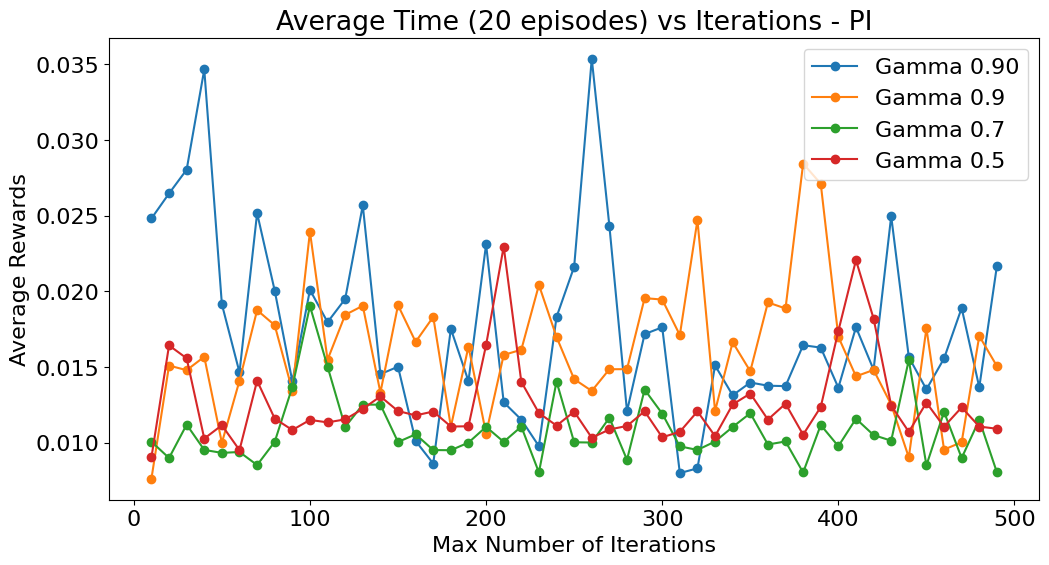

In [ ]:
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.99, "Time"],marker='o', label='Gamma 0.90')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.9, "Time"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.7, "Time"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.5, "Time"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Time (20 episodes) vs Iterations - PI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

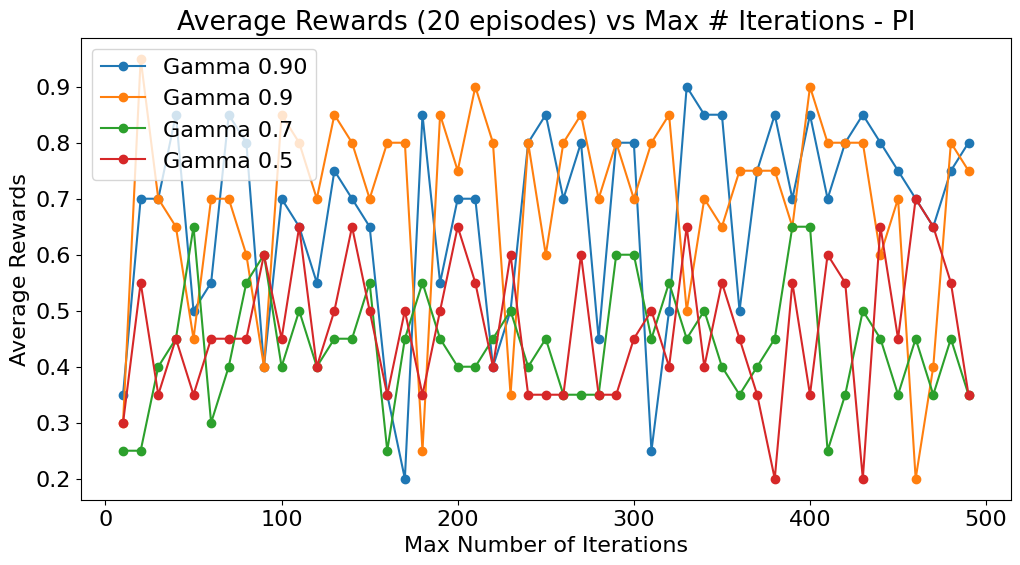

In [ ]:
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.99, "Average Reward"],marker='o', label='Gamma 0.90')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.9, "Average Reward"],marker='o', label='Gamma 0.9')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.7, "Average Reward"],marker='o', label='Gamma 0.7')
plt.plot(iterations_range,pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==0.5, "Average Reward"],marker='o', label='Gamma 0.5')

plt.xlabel('Max Number of Iterations')
plt.ylabel('Average Rewards')
plt.title('Average Rewards (20 episodes) vs Max # Iterations - PI')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

Text(0.5, 1.0, 'Average Rewards vs Discount Factors')

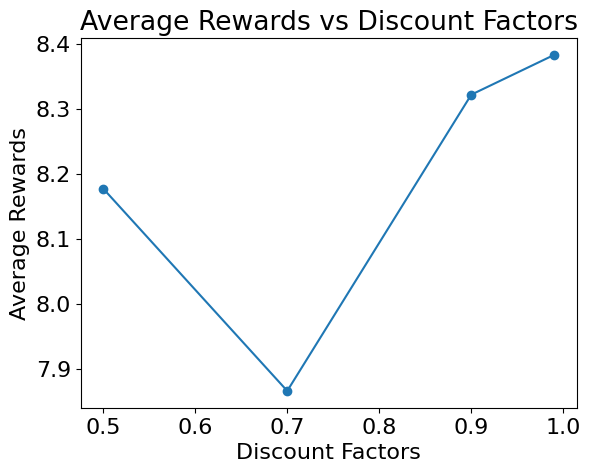

In [ ]:
y = [pi_iterations_results_df.loc[pi_iterations_results_df['Discount Factor']==g, "Average Reward"].mean() for g in discount_factors]
plt.plot(discount_factors, y, marker='o')
plt.xlabel("Discount Factors")
plt.ylabel("Average Rewards")
plt.title("Average Rewards vs Discount Factors")

# 3. Q_learning

In [534]:
def run_q_learning_exp(t, r, gammas, alphas, alpha_decays, epsilon_decays, max_iterations=10000):
    start_time = time.time()
    q_learning_iterations = []

    test_number = 0

    for gamma in gammas:
        for alpha in alphas:
            for alpha_decay in alpha_decays:
                for epsilon_decay in epsilon_decays:
                    print (gamma, alpha, alpha_decay, epsilon_decay)
                    ql = QLearning(t, r, gamma, alpha, alpha_decay, epsilon_decay, n_iter=max_iterations)
                    test_run = ql.run()

                    max_reward = test_run[-1]['Reward'] # max reward
                    time_to_converge = test_run[-1]['Time'] # time to converge
                    num_iters = test_run[-1]['Iteration'] # number of iterations to converge
                    reward = test_run[-1]['Max V'] # max V value

                    # Collect mean V, max V and errors
                    max_r, mean_r, errors = [], [], []
                    for run in test_run:
                        max_r.append(run['Max V'])
                        mean_r.append(run['Mean V'])
                        errors.append(run['Error'])

                    policy = np.array(ql.policy)
                    #policy
                    #policy = policy.reshape((4,4))
                    q_learning_iterations.append([gamma, alpha, alpha_decay, epsilon_decay, max_reward, time_to_converge, 
                                                num_iters, reward, max(max_r), max(mean_r), max(errors), policy])
                    test_number += 1
                    end_time = time.time() - start_time

    #print ("Policy>>",policy)

    q_learning_iterations_df = pd.DataFrame(q_learning_iterations, columns=['Gamma', 'Alpha', 'Alpha Decay', 'Epsilon Decay', 'Max Reward', 'Time to Converge', 'Num Iters', 'Reward', 'Max V (All)', 'Mean V (All)', 'Errors', 'Policy'])
    #print('Time to converge: ', end_time)

    #print (value_iterations_df.head())
    
    # See differences in policy
    policies = q_learning_iterations_df['Policy']
    '''
    for i, policy in enumerate(policies):
        pol = np.array(policy)
        #print (pol)
        steps, steps_stddev, failures = get_number_of_steps(env, pol)
        q_learning_iterations_df.loc[i, 'Mean Steps'] = steps
        q_learning_iterations_df.loc[i, 'Std Steps'] = steps_stddev
        q_learning_iterations_df.loc[i, 'Failures'] = failures
    '''
    q_learning_iterations_df.fillna(0, inplace=True)
    return q_learning_iterations_df

In [535]:
# Changing value of Gamma
gamma_values = [0.1,0.3, 0.5,0.7,0.9]
alphas = [0.01,0.05,0.1,0.5,0.9]
alpha_decays = [0.5, 0.9, 0.99]
epsilons = [1e-5, 1e-6, 1e-7, 1e-8]

# Define the transition probability matrix and reward matrix from the environment
P = construct_transition_matrix(env)
R = construct_reward_matrix(env)

q_learning_iterations = run_q_learning_exp(P, R, gamma_values, alphas, alpha_decays, epsilons)
q_learning_iterations.to_csv('q_learning_iterations_taxi.csv', index=False)
q_learning_iterations.head()

0.1 0.01 0.5 1e-05
0.1 0.01 0.5 1e-06
0.1 0.01 0.5 1e-07
0.1 0.01 0.5 1e-08
0.1 0.01 0.9 1e-05
0.1 0.01 0.9 1e-06
0.1 0.01 0.9 1e-07
0.1 0.01 0.9 1e-08
0.1 0.01 0.99 1e-05
0.1 0.01 0.99 1e-06
0.1 0.01 0.99 1e-07
0.1 0.01 0.99 1e-08
0.1 0.05 0.5 1e-05
0.1 0.05 0.5 1e-06
0.1 0.05 0.5 1e-07
0.1 0.05 0.5 1e-08
0.1 0.05 0.9 1e-05
0.1 0.05 0.9 1e-06
0.1 0.05 0.9 1e-07
0.1 0.05 0.9 1e-08
0.1 0.05 0.99 1e-05
0.1 0.05 0.99 1e-06
0.1 0.05 0.99 1e-07
0.1 0.05 0.99 1e-08
0.1 0.1 0.5 1e-05
0.1 0.1 0.5 1e-06
0.1 0.1 0.5 1e-07
0.1 0.1 0.5 1e-08
0.1 0.1 0.9 1e-05
0.1 0.1 0.9 1e-06
0.1 0.1 0.9 1e-07
0.1 0.1 0.9 1e-08
0.1 0.1 0.99 1e-05
0.1 0.1 0.99 1e-06
0.1 0.1 0.99 1e-07
0.1 0.1 0.99 1e-08
0.1 0.5 0.5 1e-05
0.1 0.5 0.5 1e-06
0.1 0.5 0.5 1e-07
0.1 0.5 0.5 1e-08
0.1 0.5 0.9 1e-05
0.1 0.5 0.9 1e-06
0.1 0.5 0.9 1e-07
0.1 0.5 0.9 1e-08
0.1 0.5 0.99 1e-05
0.1 0.5 0.99 1e-06
0.1 0.5 0.99 1e-07
0.1 0.5 0.99 1e-08
0.1 0.9 0.5 1e-05
0.1 0.9 0.5 1e-06
0.1 0.9 0.5 1e-07
0.1 0.9 0.5 1e-08
0.1 0.9 0.9 1e-05
0.1 0.

,Gamma,Alpha,Alpha Decay,Epsilon Decay,Max Reward,Time to Converge,Num Iters,Reward,Max V (All),Mean V (All),Errors,Policy
0,0.1,0.01,0.5,1.000000e-05,-1.0,2.397223,10000,0.002400,0.002400,0.000000e+00,0.1000,"[2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 1, ..."
1,0.1,0.01,0.5,1.000000e-06,-1.0,2.085213,10000,0.000320,0.000320,0.000000e+00,0.0125,"[0, 1, 1, 1, 0, 1, 3, 0, 3, 0, 3, 0, 0, 1, 0, ..."
2,0.1,0.01,0.5,1.000000e-07,20.0,2.116720,10000,0.000028,0.000028,5.999995e-09,0.1000,"[1, 0, 1, 0, 1, 1, 1, 3, 3, 0, 1, 3, 3, 2, 1, ..."
3,0.1,0.01,0.5,1.000000e-08,-1.0,2.098613,10000,0.000003,0.000003,9.000000e-10,0.1000,"[3, 1, 3, 3, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, ..."
4,0.1,0.01,0.9,1.000000e-05,-1.0,2.080952,10000,0.002400,0.002400,0.000000e+00,0.0900,"[2, 2, 0, 1, 0, 0, 3, 1, 1, 3, 1, 1, 0, 1, 3, ..."


In [537]:
q_learning_iterations["Max Reward"].value_counts()

Max Reward
-1.0     276
-10.0     23
 20.0      1
Name: count, dtype: int64

### Experiment 2

In [538]:
def implement_q_learning(discount_factor, decay, alpha):
    # Capture rewards over multiple episodes
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    train_episodes = 1000
    max_steps = 100
    max_epsilon, min_epsilon = 1, 0.01
    epsilon = 1
    training_rewards, training_times = [], []
    init_time = time.time()

    env.reset()

    for each_episode in range(train_episodes):
        state = env.reset()[0]
        total_reward = 0
        for step in range(max_steps):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            next_state, reward, done, info, _ = env.step(action)
            Q[state, action] = Q[state, action] + alpha * (reward + discount_factor * np.max(Q[next_state, :]) - Q[state, action])
            total_reward += reward
            state = next_state
            if done:
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * each_episode)
        training_rewards.append(total_reward)
        training_times.append(time.time() - init_time)
    return training_rewards, training_times, Q


# Gamma

0.99
0.9
0.7
0.5


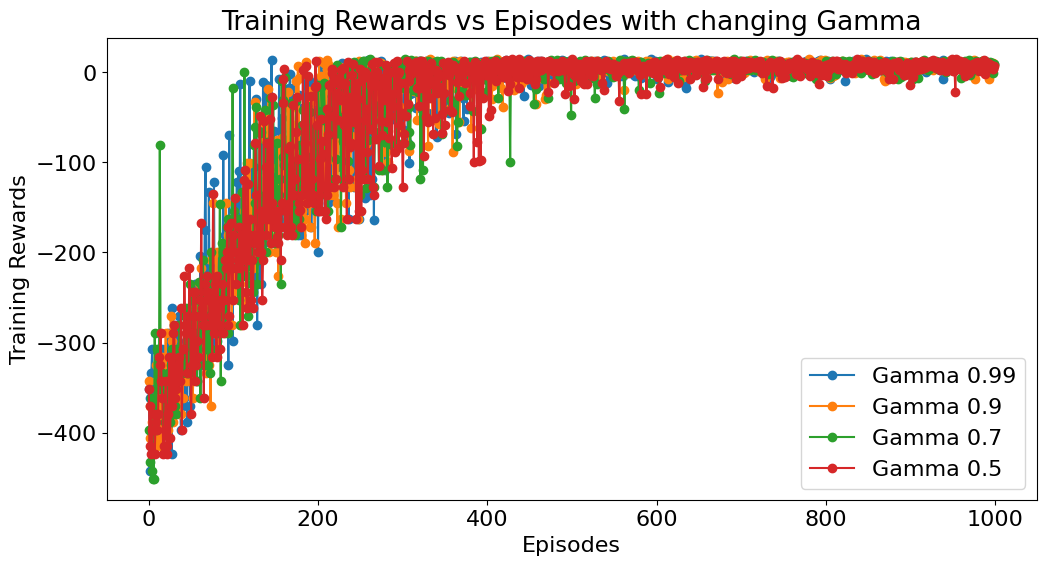

In [539]:
gamma_values = [0.99, 0.9, 0.7, 0.5]
for each_gamma in gamma_values:
    print (each_gamma)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=each_gamma, decay=0.01, alpha=0.7)
    plt.plot(training_rewards, label=f"Gamma {each_gamma}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with changing Gamma')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

0.99
0.9
0.7
0.5


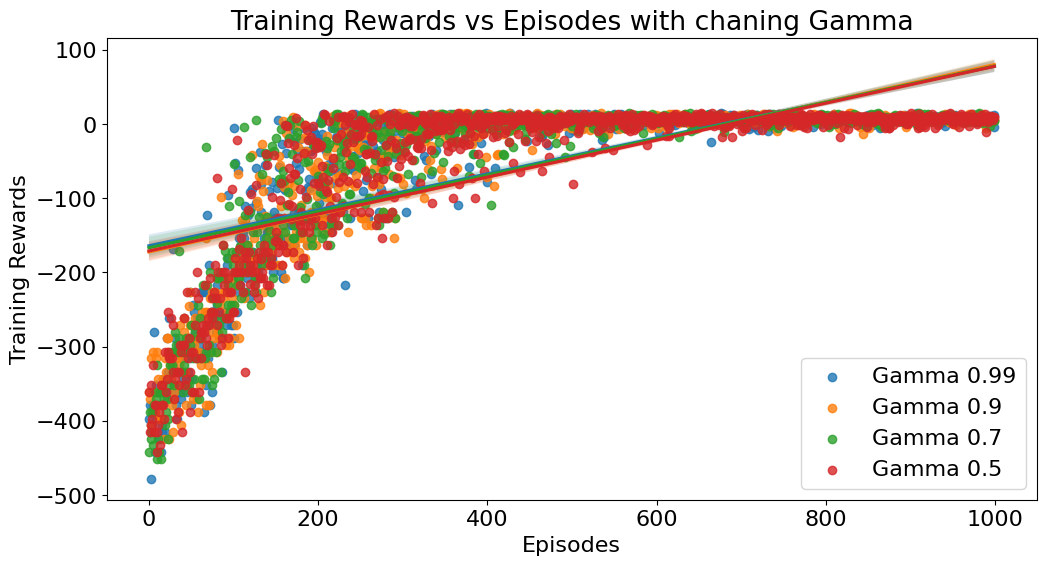

In [540]:
gamma_values = [0.99, 0.9, 0.7, 0.5]
for each_gamma in gamma_values:
    print (each_gamma)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=each_gamma, decay=0.01, alpha=0.7)
    sns.regplot(x=np.array(range(len(training_rewards))), y=training_rewards, label=f"Gamma {each_gamma}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Gamma')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

# Alpha

0.9
0.7
0.5
0.3
0.1


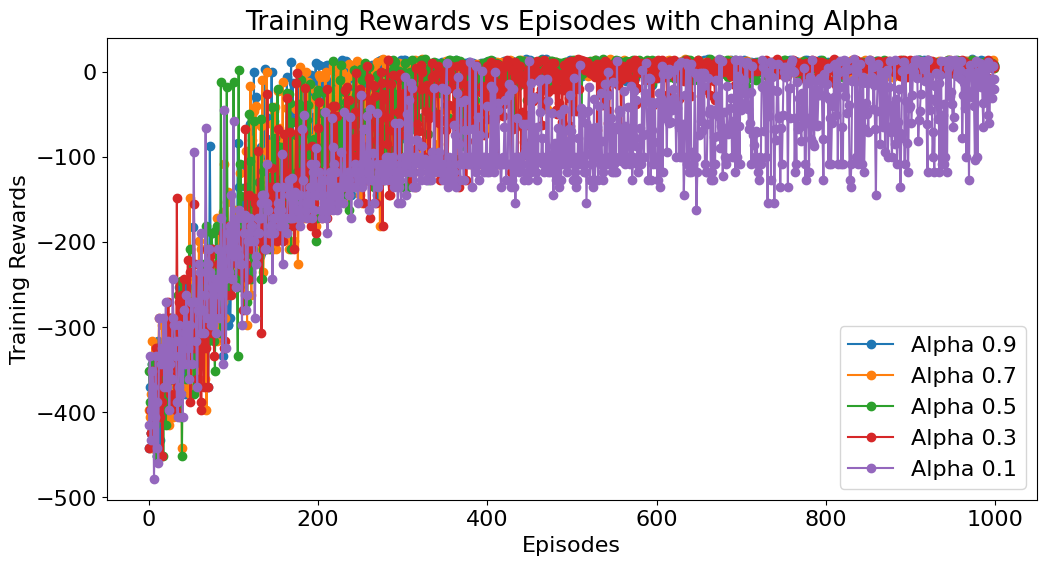

In [541]:
# Plotting for different alpha values
alpha_values = [0.9, 0.7, 0.5, 0.3, 0.1]
for each_alpha in alpha_values:
    print (each_alpha)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=0.01, alpha=each_alpha)
    plt.plot(training_rewards, label=f"Alpha {each_alpha}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Alpha')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

0.9
0.7
0.5
0.3
0.1


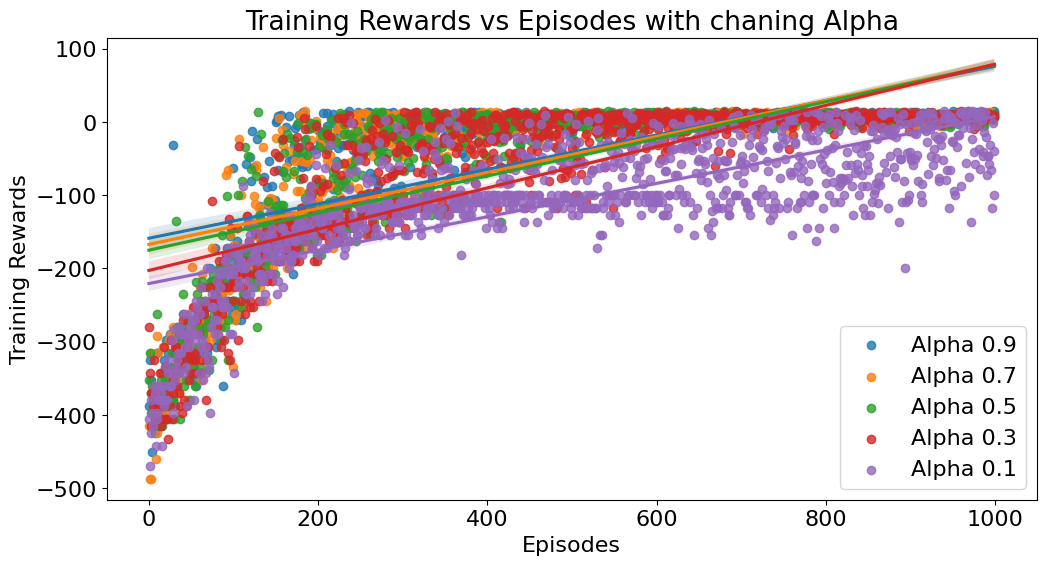

In [542]:
# Plotting for different alpha values
alpha_values = [0.9, 0.7, 0.5, 0.3, 0.1]
for each_alpha in alpha_values:
    print (each_alpha)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=0.01, alpha=each_alpha)
    sns.regplot(x=np.array(range(len(training_rewards))), y=training_rewards, label=f"Alpha {each_alpha}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with chaning Alpha')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)

# Decay

0.99
0.5
0.09
0.01


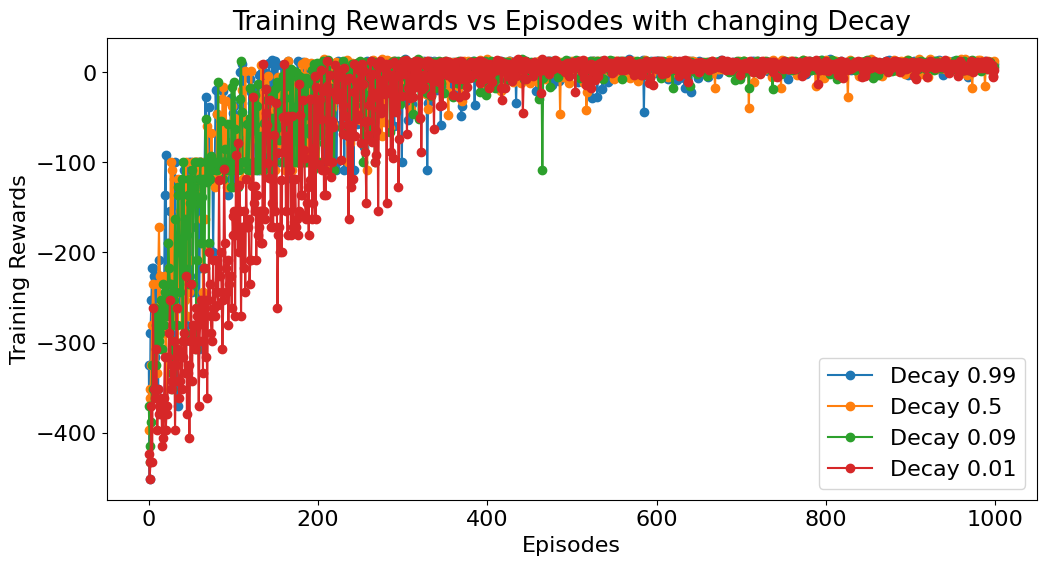

In [543]:
# Plotting for different decay values
decay_values = [0.99, 0.5, 0.09, 0.01]
for each_decay in decay_values:
    print (each_decay)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=each_decay, alpha=0.7)
    plt.plot(training_rewards, label=f"Decay {each_decay}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with changing Decay')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)


0.99
0.5
0.09
0.01


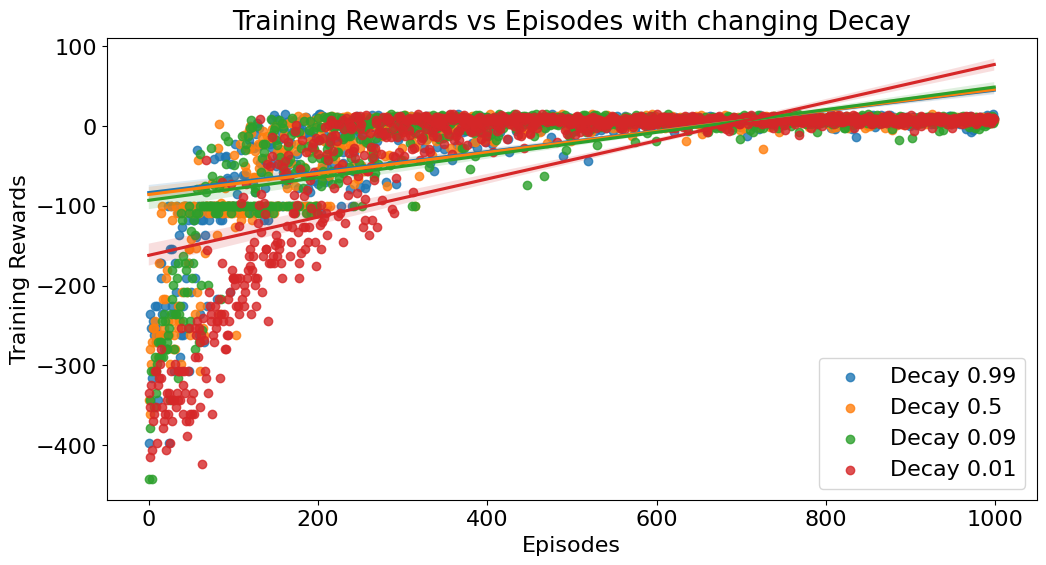

In [544]:
# Plotting for different decay values
decay_values = [0.99, 0.5, 0.09, 0.01]
for each_decay in decay_values:
    print (each_decay)
    training_rewards, training_times, Q = implement_q_learning(discount_factor=0.9, decay=each_decay, alpha=0.7)
    sns.regplot(x=np.array(range(len(training_rewards))), y=training_rewards, label=f"Decay {each_decay}", marker='o')
plt.xlabel('Episodes')
plt.ylabel('Training Rewards')
plt.title('Training Rewards vs Episodes with changing Decay')
plt.legend()
fig=plt.gcf()
fig.set_size_inches(12,6)
